In [ ]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

df = pd.read_csv('../data/processed_data/feature_engineered.csv')
df

,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,1,-455,1,11.77,11.770000,0.00,0.0
1,2,-444,2,89.00,44.500000,0.00,0.0
2,3,-127,5,139.47,27.894000,16.99,1.0
3,4,-110,4,100.50,25.125000,0.00,0.0
4,5,-88,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...
23565,23566,-372,1,36.00,36.000000,0.00,0.0
23566,23567,-372,1,20.97,20.970000,0.00,0.0
23567,23568,-344,3,121.70,40.566667,0.00,0.0
23568,23569,-372,1,25.74,25.740000,0.00,0.0


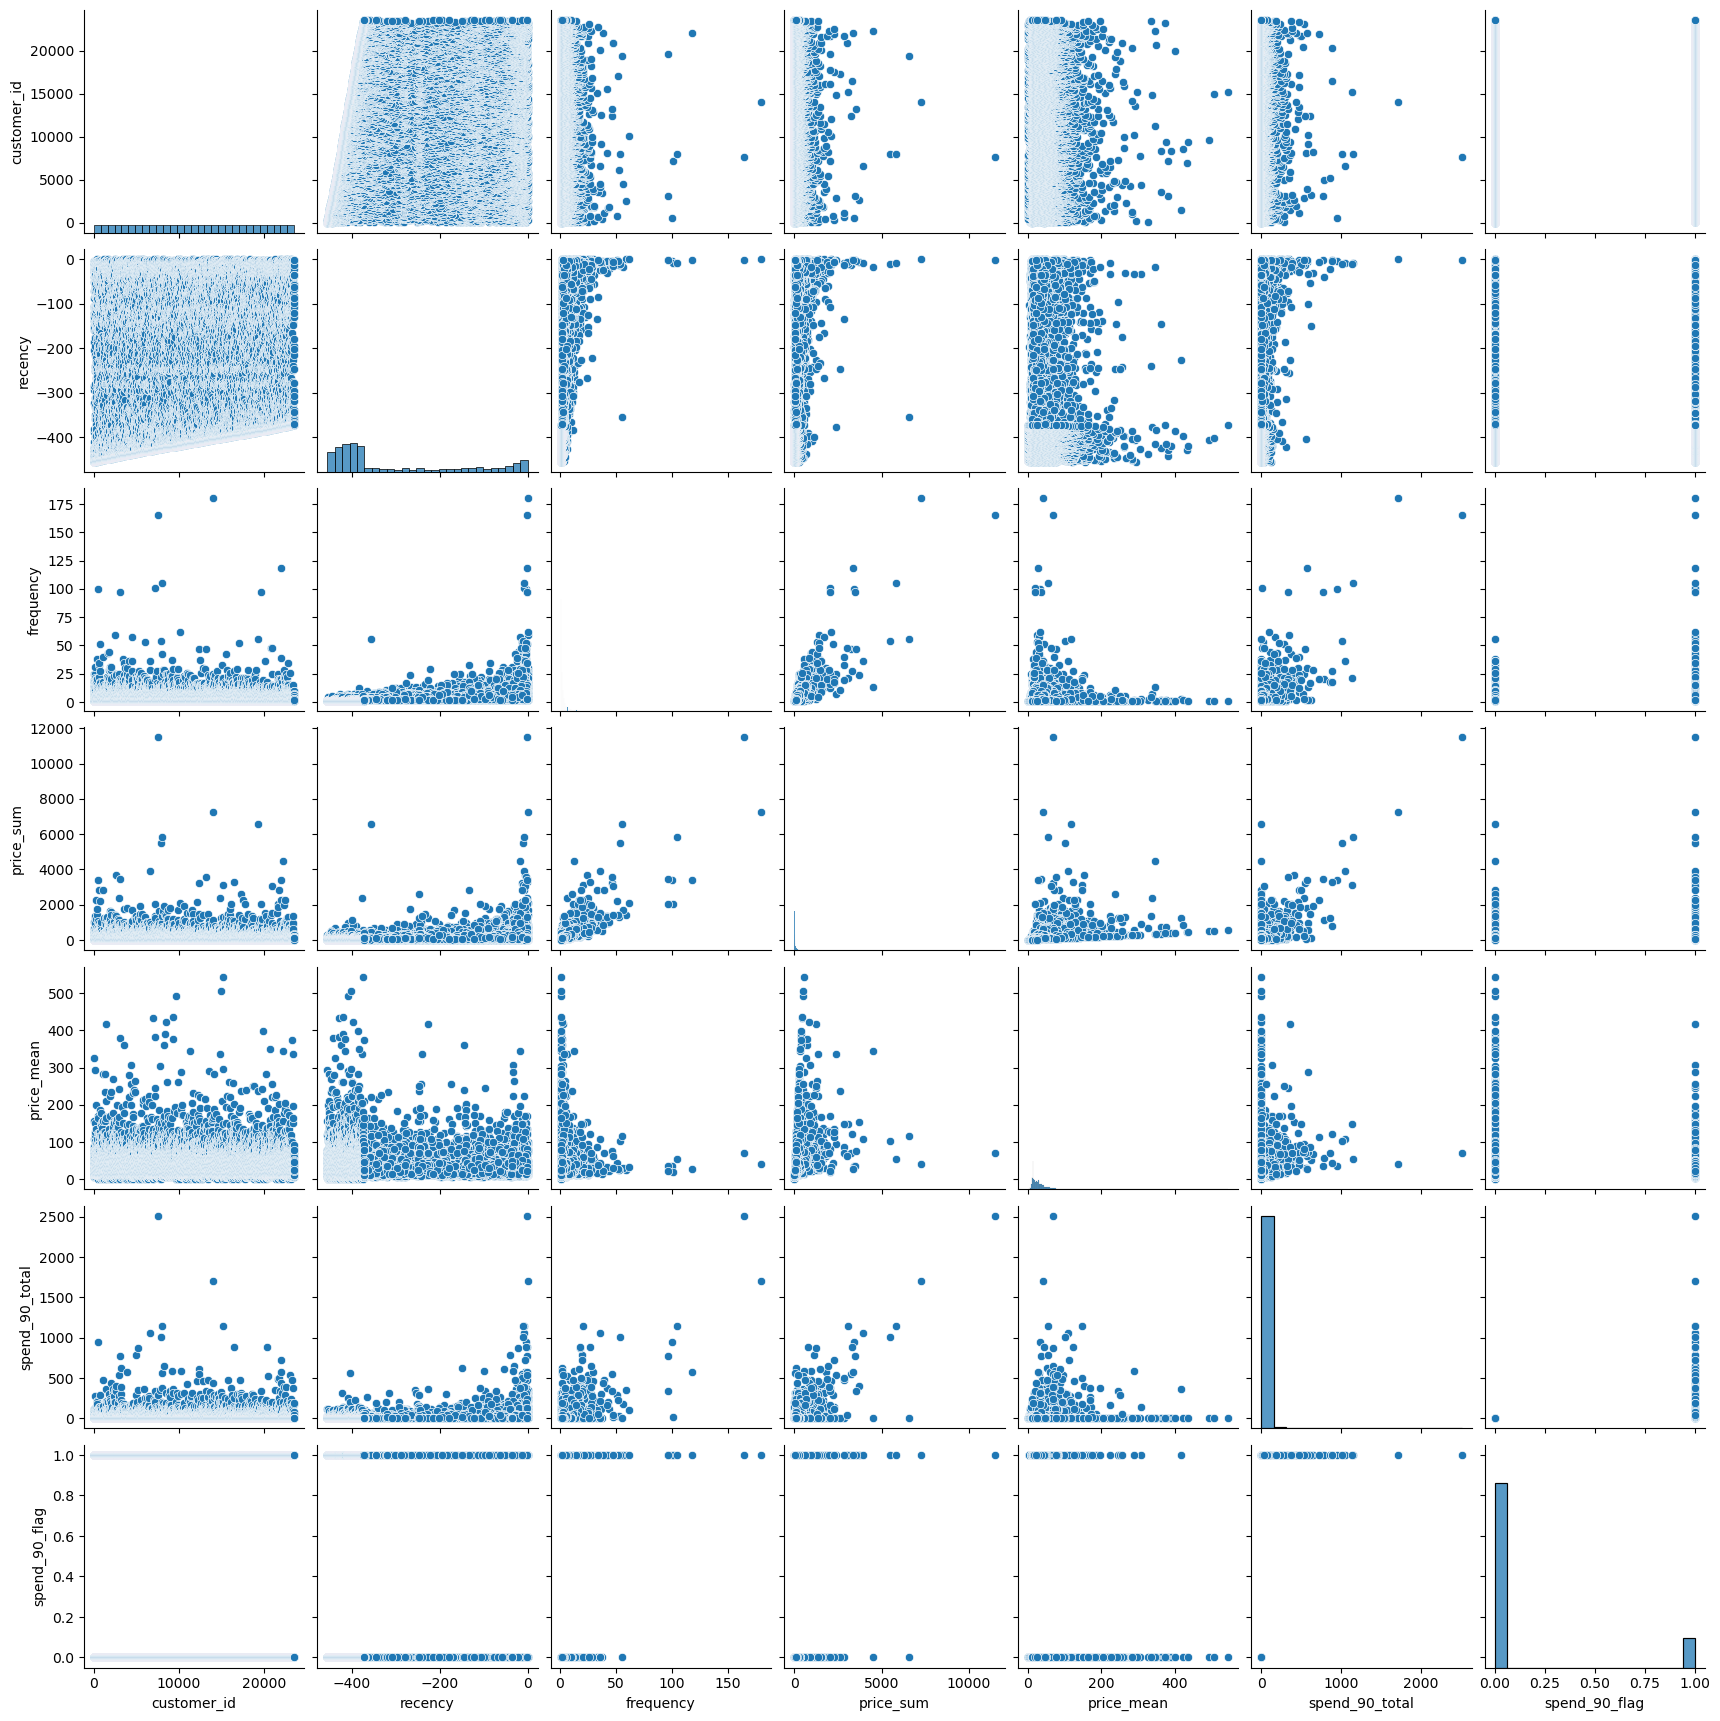

In [92]:
sns.pairplot(df)
plt.show()

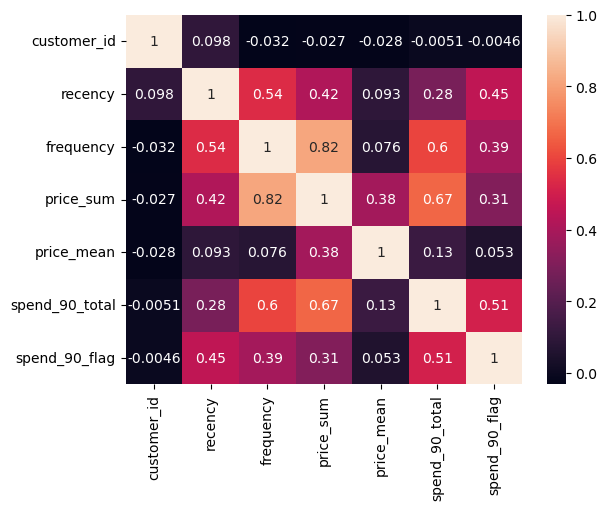

In [103]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [94]:
X = df[['recency', 'frequency', 'price_sum', 'price_mean']]
y = df['spend_90_total']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

In [96]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [97]:
y_pred

array([4.852625  , 2.5763128 , 0.88741785, ..., 7.679015  , 2.9379694 ,
       1.0297793 ], dtype=float32)

In [98]:
grid_search.best_score_

-9.652278541824849

In [99]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}

In [100]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42)

rfr.fit(X_train, y_train)

train_predictions = rfr.predict(X_train)
test_predictions = rfr.predict(X_test)

print('CLV Model Performance:')
print(f'Training RMSE {np.sqrt(mean_squared_error(y_train, train_predictions)):.2f}')
print(f'Testing RMSE {np.sqrt(mean_squared_error(y_test, test_predictions)):.2f}')

CLV Model Performance:
Training RMSE 25.26
Testing RMSE 37.82


In [104]:
feature_imp_dict = best_model.get_booster().get_score(importance_type='gain')

In [105]:
feature_imp_df = pd.DataFrame(
  data={
    'feature': list(feature_imp_dict.keys()),
    'value': list(feature_imp_dict.values())
  }
)

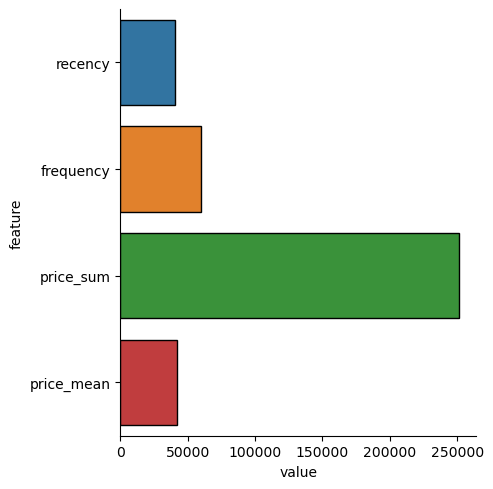

In [108]:
sns.catplot(data=feature_imp_df, x='value', y='feature', kind='bar', edgecolor='black')
